## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.signal as ss
import matplotlib
import matplotlib.pyplot as plt
import os

from mpdaf.obj import Cube
from mpdaf.sdetect import Source

from shade import proba_tools,shade_main,parameters

%matplotlib inline
plt.rcParams['image.origin']='lower'
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['figure.figsize']=(10,10)

 ## Import data

In [3]:
listSrc = [Source.from_file("./data/"+filename) for filename in os.listdir("./data") if filename.endswith(".fits")]

## What is a source object

A mpdaf source object is a descriptor of a region of a small region of a MUSE field, centered around a source (galaxie, star...)
It is composed of several objects (images, cubes, lines...). For more details on mpdaf source object see http://mpdaf.readthedocs.io/en/latest/source.html

To get infos about the first source of the listSrc :

In [14]:
src=listSrc[0]
src.info()

[INFO] RAF_ID  = '9863    '           / Rafelski catalog ID                            
[INFO] FORMAT  = '0.5     '           / Version of the Source format                   
[INFO] FSF00FWA=                0.869                                                  
[INFO] CAT3DHST= '3DHST 4.1.5'        / Name of 3DHST Catalog                          
[INFO] COE_ID  =                 7868 / Coe catalog ID                                 
[INFO] DEFECT  =                    0 / Defect Flag                                    
[INFO] CUBE_V  = '0.42    '           / version of the datacube                        
[INFO] FROM_V  = '2.20    '           / version of the detection software              
[INFO] ID_3DHST=                28768 / 3DHST ID                                       
[INFO] EXPMIN  =                   63 / Minimum value of EXPMAP                        
[INFO] FSF00FWB=           -3.401E-05                                                  
[INFO] DEC     =         -27.779

To see a white image of the source :

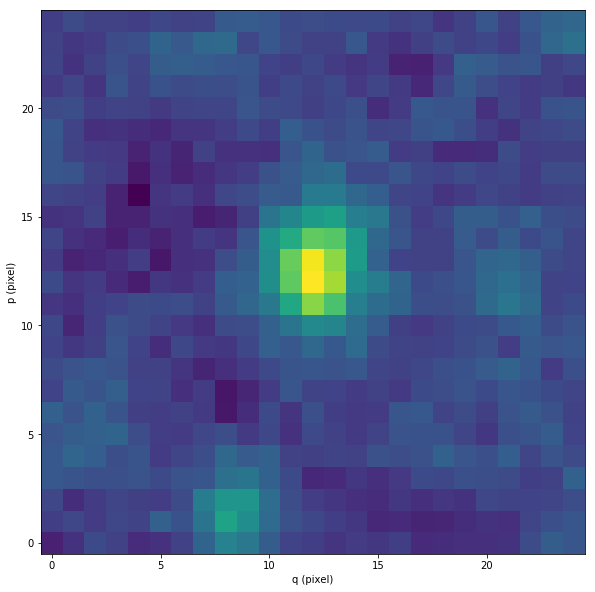

In [15]:
src.images['MUSE_WHITE'].plot()

The muse datacube of the source is stored in 


In [16]:
src.cubes['MUSE_CUBE']

<Cube(shape=(3681, 25, 25), unit='1e-20 erg / (Angstrom cm2 s)', dtype='float64')>

To get the numpy (masked) array of a mpdaf image or cube, get the data extension :


In [21]:
type(src.cubes['MUSE_CUBE'].data)

numpy.ma.core.MaskedArray

## Do halo detection

In [10]:
### Choose parameters
# sim=False : il ne s'agit pas d'une source simu, on permet
# lmbdaShift : max variation in the created spectra dictionnary (we go from -lmbdaShift to + lmbdaShift)
# LW : half-width of the wavelength area

params=parameters.Params(sim=False,lmbdaShift=7,LW=15)

### creation de l'objet méthode à partir de la liste d'ID, cela permet de construire des sources plus grandes que celles obtenues dans le catalogue
# on peut sinon injecter une liste de sources avec listSources=
shade1=shade_main.SHADE(params=params,listSources=listSrc) 

#preprocessing with parameters : here, we do continuum subtraction using median filtering and we apply always preprocessing (i.e. even if preprocessed data is detected)
paramsPreProcess=parameters.ParamsPreProcess(methodRC='medfilt',forceProcess=True,unmask=False)
shade1.preprocess(paramsPreProcess=paramsPreProcess)


### Detection
paramsDetection=parameters.ParamsDetection()
shade1.detect()

### PostProcess
# FDR: control with FDR 
# qvalue: compute qvalues
# newSource : store results in a new source object (if not results are added to the input sources)
# resizeCube : if whole muse cube given, resize cube in result sources to explored regions
paramsPostProcess=parameters.ParamsPostProcess(threshold=0.1,
                 FDR=True,
                 qvalue=True,
                 newSource=False,
                 resizeCube=False)

shade1.postprocess(paramsPostProcess=paramsPostProcess)

## Results

Here results are stored inside the original sources.
We added new images : 'DET_STAT' (pvalues map) and 'DET_BIN' (binary map for BH procedure with the FDR threshold given above)

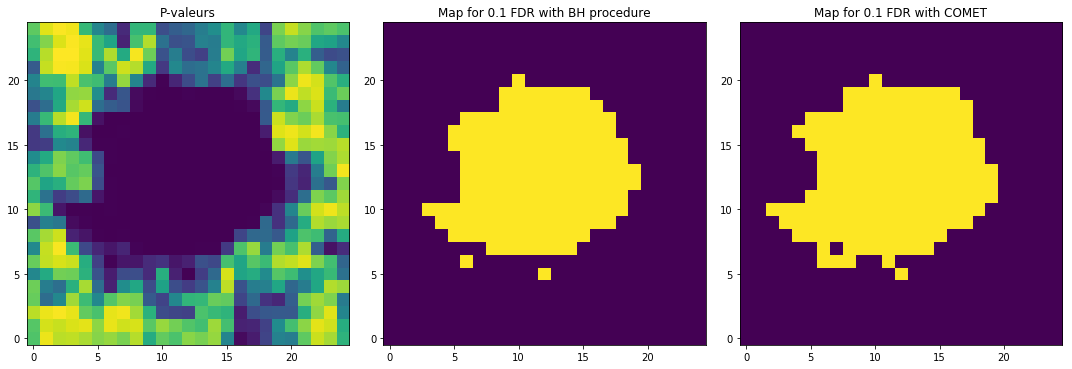

In [18]:
plt.rcParams["figure.figsize"]=(15,15)
plt.subplot(131)
plt.title('P-valeurs')
plt.imshow(shade1.listSources[0].images['DET_STAT'].data)
plt.subplot(132)
plt.title(u'Map for 0.1 FDR with BH procedure')
# We can directly get the binary map shade1.listSources[0].images['DET_BIN']
# or
# we can compute a threshold for pvalues for another FDR and apply it on DET_STAT
# In this case as in postprocess we put a 0.1 threshold.

#Threshold on pvalues for FDR =0.1
seuil=shade1.postprocessing.corrPvalueBH(shade1.listSources[0].images['DET_STAT'].data,0.1)
plt.imshow(shade1.listSources[0].images['DET_STAT'].data<seuil)

plt.subplot(133)
# Here we exploit connexity (COMET approach) we get the following detection for a 0.1 FDR.
plt.title(u'Map for 0.1 FDR with COMET')
plt.imshow(proba_tools.connexAggr(shade1.listCorrArr[0],q=0.1))
plt.tight_layout()